# Bond Valuation and Analysis in R

* Chapter 1: Bond Valuation
* Chapter 2: Estimating Yield to Maturity
* Chapter 3: Duration and Convexity
* Chapter 4: Comprehensive Example

## Chap Introduction and Plain Vanilla Bond Valuation

### Examples 

Examples will be based on bonds with yearly coupons with a fixed maturity, not callable bonds


### Defnitions
**par value**  is bond's face value

**coupon**  is bond's interest rate payable periodically

**maturity** date  is a date when a bon'ds par value is payed back to inverstor

##### Time value of Value (TVM)
FV = PV*(1+r) FV Future Value, PV Present Value, r interest rate

###### interest compounding
fv = pv * (1+r1)*(1+r2)

##### getting a present value from a future value
$$PV_0 = \frac{FV_i}{\prod_1^i (1+r_i)}$$

#### coupon's payments serie
$$V = \sum_{t=1}^{T-1} \frac{C_t}{(1+y)^t} $$ 

where $C_t$ is a coupon payed at $t$ th period, $y$ is a yield

### value of coupons and maturity  serie
$$V = \sum_{t=1}^{T-1} \frac{C_t}{(1+y)^t}  + \frac{C_T + P}{(1+y)^T}  $$

where P is a principal repayment




[1] "bond value with par=100$,coupon=5$, yearly yieled y=6%: 95.7876362144343"

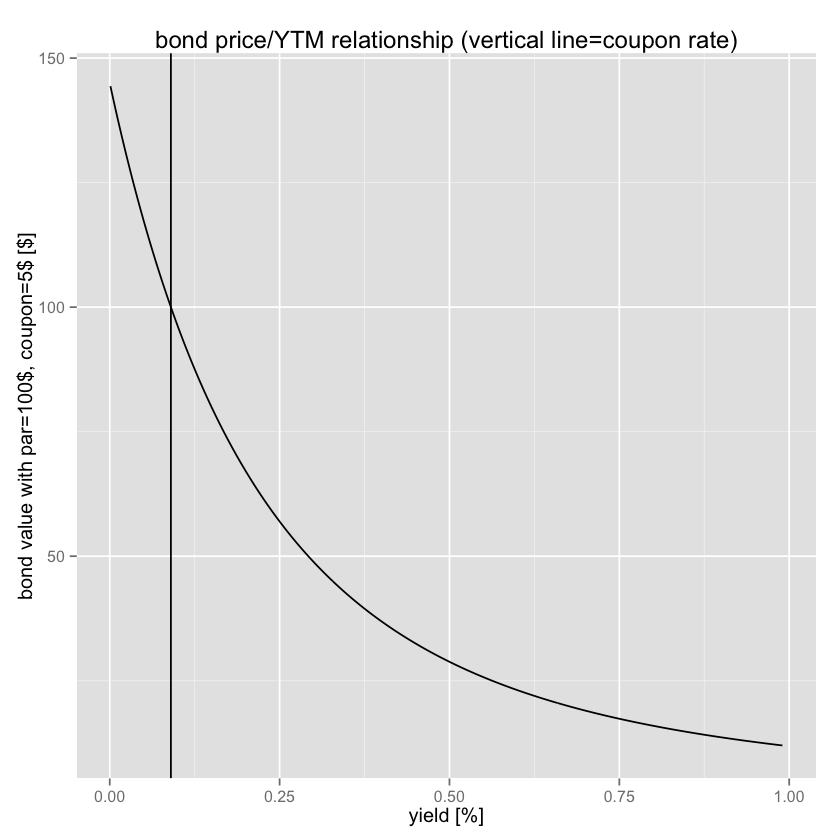

In [6]:
require(ggplot2)
## convert your code into a bond valuation function

# Create function
bondprc <- function(p, r, ttm, y) {
  cf <- c(rep(p * r, ttm - 1), p * (1 + r))  #cash flows  c(5,5,5,..,105)
  cf <- data.frame(cf)
  cf$t <- as.numeric(rownames(cf))          # c(1,2,...ttm)
  cf$pv_factor <- 1 / (1 + y)^cf$t         
  cf$pv <- cf$cf * cf$pv_factor     #present value of every factor 
  sum(cf$pv)     #price of a bond is a sum of ot its cash flows present values
}
# Verify prior result
paste('bond value with par=100$,coupon=5$, yearly yieled y=6%:'
      , bondprc(p=100, r=0.05, ttm=5, y=0.06))


# lets investigate a relation between a changing market yield and 
# and a bond price with a fixed coupon
rvalue<-0.09 # fix the coupon rate
ylds<-seq(0.001,0.99,length=300)
bp<-rep(NA,length(ylds))
#compute bond price for different yields in a loop
for( i in 1:length(bp)) {
    bp[i] <- bondprc(p=100, r=rvalue, ttm=5, y=ylds[i])
}
##plot the bond price as a function of yield
df<-data.frame(ylds,bp)
ggplot(df, aes(x=df$ylds, y=df$bp)) + geom_line() + 
geom_vline(xintercept = rvalue) +
labs(x="yield [%]", y='bond value with par=100$, coupon=5$ [$]') +
ggtitle("bond price/YTM relationship (vertical line=coupon rate)")


## Credit Ratings

#### The lower the rating the higher the bond yield (coupon), the higher is a risk of a bond (credit risk = probability of default of  a bond's issuer ) 

* **Investment grade** [AAA - BBB]
* **High Yield (junk bonds** [BB - CCC, lower ]

!NB Many institutions choose to invest only in Investment grade bonds

* Use yields of bonds with the same credit rating 
* if we want to value a BAA rated bonds, we get the data from **Quandl** R package

In [35]:
## Value the 5% bond using the Baa yield you found
library(Quandl)
Quandl.api_key("dCbRAxPkcnxxxzTtDFW5")
baa<-Quandl("MOODY/DBAAYLD")
# Identify 9/30/16 yield
baa_yield <- subset(baa, baa$DATE == "2016-09-30")
# Convert yield to decimals and view
baa_yield <- baa_yield$VALUE * 0.01 # 4.29%

paste('baa_yield as of 2016-09-30:', baa_yield)
paste('value of baa bond with coupon at 5%:'
      ,bondprc(p = 100, r = 0.05, ttm = 5, y = 0.0429))


[1] "baa_yield as of 2016-09-30: 0.0429"

[1] "value of baa bond with coupon at 5%: 103.135207912681"

## Baseline Component of Yield
#### Risk-free yield (baseline rate has zero risk of default)

* Yield on recently issued US Treasury with similar maturity
* Risk-free yield is not constant
    * Affected by economy, market interest rates and inflation

##### can be obtained from the Treasury data database FRED  (example in next cell)


### Spread Component of Yield
 * Corporate bond is riskier than a treasury bill
 * the difference between a corporate bond and a treasure bill is a **spread**
 * the spread is primarily comprosed of **credit risk** (a risk  that issuer will default beform TTM)
 * other risks: 
     * **Inflation Risk**: Risk that inflation eats up value of cash flows received from bond
     * **Call Risk**: Risk that issuer will buysback the bond before TTM (callable bond)
     * **Liquidity Risk**: Risk that a buyer cannot sell the bond for a price that is at its value
         * Many bonds do not trade frequently. So they are subject to a liquidity risk

### Time-Varying Risk premiums
* Depends on market's current appetite for risk
* Nervous markets -> larger risk premium
* We can observe an Investment Grade spread (i.e. difference in BAA and AAA yields)
    * available through **Quandl** package


In [34]:
##obtaining 10 year ttm treasury t10 bill serie
library(quantmod)

t10yr <- getSymbols("DGS10", src="FRED", auto.assign = FALSE)
head(t10yr)

Warning message:
: package 'quantmod' was built under R version 3.3.2Loading required package: TTR
Warning message:
: package 'TTR' was built under R version 3.3.2Version 0.4-0 included new data defaults. See ?getSymbols.
    As of 0.4-0, 'getSymbols' uses env=parent.frame() and
 auto.assign=TRUE by default.

 This  behavior  will be  phased out in 0.5-0  when the call  will
 default to use auto.assign=FALSE. getOption("getSymbols.env") and 
 getOptions("getSymbols.auto.assign") are now checked for alternate defaults

 This message is shown once per session and may be disabled by setting 
 options("getSymbols.warning4.0"=FALSE). See ?getSymbols for more details.


           DGS10
1962-01-02  4.06
1962-01-03  4.03
1962-01-04  3.99
1962-01-05  4.02
1962-01-08  4.03
1962-01-09  4.05

# Chap 3 Bond Price Volatility and Price Value of a Basic Point
## Estimating the Yield of a Bond

If you have a bond's traded price you can estimate its yield  iteratively (by trial and error, try various yields untill we match the bond price) 


In [5]:
##Use uniroot function to find YTM
bprice<-95.79 #listed trading price of a bond
coupon<-5
par<-100
ttm<-5
cf<-c(-bprice, rep(coupon,ttm-1), coupon+par)

bval <- function(x, cf, t=seq(along = cf)){ 
  sum(cf / (1 + x)^t)
}

# Create ytm() function using uniroot
#estimates a solution inside the interval [0,1]  i.e. annual yield between 0 and 100%
ytm <- function(cf) {
  uniroot(bval, c(0, 1), cf = cf)$root
}
ytm(cf) ## the ipmplied yield from the bond pric  

[1] 0.05999552

### Bond price change of for 1 b.p change in yield
also named  PV01

#### Small changes in  yield  postive and negative have a symmetric impact on the bond's price with a negative sign

#### Large changes in yield are assymetric

In [8]:
#Calculate PV01 of a 10% bond
par<-100
r<-0.10
ttm<-20
y<-0.10

pv01<-abs(bondprc(par,r,ttm,y) - bondprc(par,r,ttm,y+0.0001)) #pv01
pv01_rt <- pv01/bondprc(par,r,ttm,y)  #pv01 rate

pv01
pv01_rt

[1] 0.08507756

[1] 0.0008507756

### Duration

**Duration** can sometimes be thought of as the weighted-average time to maturity of the bond

**NB!** Duration does not capture the convexity of  price/yield relationship (see chart)

For a zero coupon bond  duration is a TTM. 

* Estimated price change for 100 b.p change in yield
* Two bonds with the same duration willhave the same estimated price change
* A way to manage the risk of interest rate sensitive liabilities

Calculation of **approximate** Duration
$$D=\frac{P(yield_{down}) - P(yield_{up})}{2*P*\Delta y}$$
where $P$ is a current bond's price, $P(yield_{down})$ is a price of bond with yield down by 100 bp, $\Delta y$ a change in yield

Duration is used to estimate a bond's Price change 
$$\frac{\Delta P}{P} = -D * \Delta y$$
$$\Delta P = -D * \Delta y * P $$

### Convexity improves the estimation of price change
Calcualtion of **approximate** convexity
$$C=\frac{P(yield_{down}) + P(yield_{up}) - 2 * P }{P* (\Delta y)^2}$$

Contribution of **Convexity** to estimate a bond's Price change (always positive 
$$\frac{\Delta P_C}{P} = 0.5 * C * (\Delta y)^2 $$
$$\Delta P_C = 0.5 * C * (\Delta y)^2 * P $$

## Effect of Duration + convexity 
$$ \hat{P} = P + \Delta P + \Delta P_C $$ 
where $\hat{P}$ is an esimated price  $\Delta P$ is a contribution of duration to the price change and $\Delta P_C$ is a contribution of convexity


![conv](conv_chart.png)

In [18]:
##Calculate approximate duration for a bond

apx_duration <-function(par,r,ttm,y){
  dy<-0.01 # 100 bp
  duration <- ( bondprc(par,r,ttm, y-dy) -bondprc(par,r,ttm, y+dy) ) /
              (2 * bondprc(par,r,ttm, y) * dy)
  return(duration)
}

par<-100
r<-0.10
ttm<-20
yld<-0.10


dura<-apx_duration(par,r,ttm,yld)
paste('duration:',dura)

bpx <- bondprc(par,r,ttm, y) # price of bond

paste('for bond pice',bpx
     ,'$ change in price if yield decreases by 1.0%:', - dura * -0.01 * bpx )
paste('$ change in price if yield increases by 1.0%:', - dura * 0.01 * bpx )

[1] "duration: 8.5459368932264"

[1] "for bond pice 99.9999999999999 $ change in price if yield decreases by 1.0%: 8.5459368932264"

[1] "$ change in price if yield increases by 1.0%: -8.5459368932264"

In [23]:
##Estimating the bond price using duration and convexity

### define a convexity funtion
apx_convexity<-function(par,r,ttm,y){
  dy<-0.01 #100 bp
  conv<- ( bondprc(par,r,ttm, y-dy) + bondprc(par,r,ttm, y+dy) - 2 * bondprc(par,r,ttm, y) ) /
         (bondprc(par,r,ttm, y) * dy^2)
  return(conv)
}


## define a bond price function with additional arugemnt dy for yield change
apx_bondprc <- function(par,r,ttm,y, dy){
  
  bpx<-bondprc(par,r,ttm, y) # price of bond
  #compute duration price dollar change
  dur_dollar_delta<- -apx_duration(par,r,ttm,y) * dy * bpx
  ## compuate convexity price dollar change
  conv_dollar_delta<- 0.5 * apx_convexity(par,r,ttm,y) * dy^2 * bpx
  return(bpx + dur_dollar_delta + conv_dollar_delta)  # duration and convexity contribution
}

par<-100
r<-0.10
ttm<-20
y<-0.10
paste('bond price with no change in yield (expect 100):', apx_bondprc(par,r,ttm,y,0.0) )
paste('bond price with yield delta -0.01 (expect > 100):', apx_bondprc(par,r,ttm,y, -0.01) )
paste('bond price with yield delta +0.01 (expect < 100):', apx_bondprc(par,r,ttm,y, 0.01) )



[1] "bond price with no change in yield (expect 100): 99.9999999999999"

[1] "bond price with yield delta -0.01 (expect > 100): 109.128545669086"

[1] "bond price with yield delta +0.01 (expect < 100): 92.0366718826331"

# Chap 4 Comprehensive Example

#### yield is composed of  risk_free yield and a spread (credit, inflcation, liquidity, call risks )

Revisit materilas from previous chapters

In [28]:
### bond valuation revisited again

aaa <- Quandl("MOODY/DBAAYLD")
## check mooody's aaa yield as of sep 30 2016
aaa_yield <- subset(aaa, aaa$DATE == as.Date("2016-09-30"))
aaa_yield <- 0.01 * as.numeric(aaa_yield$VALUE)   # from downloaded data ( 0.0429)
aaa_yield <- 0.0344  # from datacamp course env

cttm<-8
par<-100
cr<-0.03 #coupon rate , aaa_yeild is 0.0429
#vector cash flows
cf <- c( rep(par*cr,cttm-1), par*(1+cr)  )
cf <- data.frame(cf)
cf$t <- seq(1,nrow(cf),1)
cf$pv_factor <- 1 / (1+aaa_yield)^cf$t
cf$pv <- cf$cf * cf$pv_factor
paste('valued price of bond:', sum(cf$pv))


[1] "valued price of bond: 96.9678713636976"

In [26]:
aaa_yield
cf

[1] 0.0429

,cf,t,pv_factor,pv
1,3,1,0.9588647,2.876594
2,3,2,0.9194215,2.758265
3,3,3,0.8816008,2.644803
4,3,4,0.8453359,2.536008
5,3,5,0.8105628,2.431688
6,3,6,0.77722,2.33166
7,3,7,0.7452489,2.235747
8,103,8,0.7145928,73.60306


#### Authors book
Clifford Ang Analyzing financial Data and Implementing Financial Models Using R
